In [142]:
from __future__ import print_function, division

import numpy as np
from torchvision import datasets, transforms, models
import torchvision
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import LoopTimer 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle

import skorch
print('bananas!')

bananas!


In [7]:
# base_dir = r"/gscratch/stf/jkcm/data/npz"
base_dir = r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/npz"

In [8]:
def check_files():
    data_loc = r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/unified_filtered/good_npz"
    for folder in os.listdir(data_loc):
        for file in os.listdir(os.path.join(data_loc, folder)):
            l = np.load(os.path.join(data_loc, folder, file))
            print(l.files)
            
def npz_loader(path):
    l = np.load(path)
    r = l['Ref_Band2']*256
    g = l['Ref_Band4']*256
    b = l['Ref_Band7']*256
    rgb = np.stack([r,g,b], axis=2).astype('uint8')
#     sample = torch.from_numpy(rgb)
    sample = Image.fromarray(rgb)
    return sample

def valid_file(path):
    return os.path.basename(path)[:3] == "IMG" and path[-4:] == '.npz'

            
# check_files()

In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
#         transforms.ToPILImage(mode='RGB'),
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.ToPILImage(mode='RGB'),
        transforms.Resize(224),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
npz_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), 
                                            transform=data_transforms[x], 
                                            target_transform=None, 
                                            loader=npz_loader,
                                            is_valid_file=valid_file)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(npz_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(npz_datasets[x]) for x in ['train', 'val']}
class_names = npz_datasets['train'].classes

data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
full_dataset = datasets.ImageFolder(r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/unified_filtered/good_npz/",
                                    transform=data_transform,
                                    target_transform=None,
                                    loader=npz_loader,
                                    is_valid_file=valid_file)
full_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=8,
                                             shuffle=True, num_workers=8)
full_size = len(full_dataset)
class_names = full_dataset.classes
# device = 'cuda'
device='cpu'
torch.set_num_threads(4)



In [11]:
# make splits
labels = [i[1] for i in full_dataset]
k = 5
classes = list(set(labels))
indices_dict = {i: [] for i in set(classes)}
#split indices by category
for i, l in enumerate(labels):
    indices_dict[l].append(i)
#define the splits
split_dict = {i: [] for i in set(classes)}
for cat,indices in indices_dict.items():
    shuffle(indices)
    in_splits = [indices[i::k] for i in range(k)]
    split_dict[cat] = in_splits
#convenience define the splits, lists are cheap
splits = []
for i in range(k):
    train_indices = np.concatenate([np.concatenate([x for j,x in enumerate(splits) if j!=i]) for splits in split_dict.values()])
    val_indices = np.concatenate([splits[i] for splits in split_dict.values()])
    splits.append({"train": train_indices, "val": val_indices})

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_final_labels = []
    best_final_preds = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            lt = LoopTimer.LoopTimer(dataset_sizes[phase]/dataloaders[phase].num_workers)
            if phase == 'val':
                final_labels = []
                final_preds = []
            for inputs, labels in dataloaders[phase]:
                lt.update()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'val':
                    final_labels.extend(labels.data.cpu().numpy().tolist())
                    final_preds.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_final_labels = final_labels
                best_final_preds = final_preds
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_final_labels, best_final_preds

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def per_cat_skill(y_true, y_pred, classes):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    match = y_true == y_pred
    print("per-category accuracy:")
    for i in np.unique(y_true):
        acc = sum(np.logical_and(y_true == i, match)) / sum(y_true == i)
        print("{}: {:0.2f}".format(classes[i], acc))

In [13]:
# model_ft = models.resnet101(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

def make_model():
    model_ft = models.densenet121(pretrained=True)
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, len(class_names))
    model_ft = model_ft.to(device)
    return model_ft

model_ft = make_model()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [79]:
## CV-version
fit_models = []
for i,split in enumerate(splits[0:1]):
    dataloaders = {x: torch.utils.data.DataLoader(full_dataset, batch_size=8, num_workers=8, 
                                             sampler=SubsetRandomSampler(split[x]))                   
              for x in ['train', 'val']}
    dataset_sizes = {x: len(split[x]) for x in ['train', 'val']}

    model = make_model()
    model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)
    fit_models.append(model_ft)

In [19]:
model, final_labels, final_preds = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
100.21%      ETA 23:19:45      time left: -1 seconds       train Loss: 1.1830 Acc: 0.5431
101.43%      ETA 23:20:15      time left: -0 seconds       val Loss: 0.9161 Acc: 0.6585

Training complete in 9m 56s
Best val Acc: 0.658487


In [20]:
pickle_dict = dict(
    model=model,
    final_labels=final_labels,
    final_preds=final_preds)

In [3]:
pickle.dump(pickle_dict, open('/home/disk/eos4/jkcm/Data/MEASURES/models/CNN-densenet-65pct.pickle', 'wb'))


NameError: name 'pickle' is not defined

In [80]:
pickle_dict = pickle.load(open('/home/disk/eos4/jkcm/Data/MEASURES/models/CNN-densenet-81pct.pickle', 'rb'))
model = pickle_dict['model']
old_final_labels = pickle_dict['final_labels']
old_final_preds = pickle_dict['final_preds']

final_labels = []
final_preds = []
final_certs = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        temp, preds = torch.max(outputs, 1)
        certs = torch.softmax(outputs, 1)
        certs_pred = certs.gather(1, preds.view(-1,1))
        loss = criterion(outputs, labels)
        final_labels.extend(labels.data.cpu().numpy().tolist())
        final_preds.extend(preds.cpu().numpy().tolist())
        final_certs.extend(certs_pred.cpu().numpy().tolist())
    

In [68]:
unknown_dataset = datasets.ImageFolder(r'/home/disk/eos4/jkcm/Data/MEASURES/classified_data/unified_filtered/other_good/npz', 
                                            transform=data_transform, 
                                            target_transform=None, 
                                            loader=npz_loader,
                                            is_valid_file=valid_file)

unknown_dataloader = torch.utils.data.DataLoader(unknown_dataset, batch_size=8,
                                             shuffle=True, num_workers=8)

other_preds = []
other_certs = []
model.eval()
lt = LoopTimer.LoopTimer(len(unknown_dataset)/unknown_dataloader.num_workers)
for inputs, labels in unknown_dataloader:
                lt.update()
                inputs = inputs.to(device)
                labels = labels.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    temp, preds = torch.max(outputs, 1)
                    certs = torch.softmax(outputs, 1)
                    certs_pred = certs.gather(1, preds.view(-1,1))
                    loss = criterion(outputs, labels)
#                     final_labels.extend(labels.data.cpu().numpy().tolist())
                    other_preds.extend(preds.cpu().numpy().tolist())
                    other_certs.extend(certs_pred.cpu().numpy().tolist())
                    

100.00%      ETA 16:24:50      time left: 0 seconds       

In [84]:
np.sum(np.array(final_preds)==np.array(final_labels))/len(final_preds)

0.8903654485049833

In [85]:
np.nanmean(max_probs)

0.8709467170246415

In [92]:
np.nanmean(other_max_probs)

0.7032188707084026

In [117]:
class_names

['closed_mcc',
 'clustered_cu',
 'disorg_mcc',
 'open_mcc',
 'solid_sc',
 'suppressed_cu']

/home/disk/p/jkcm/anaconda3/envs/measures/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


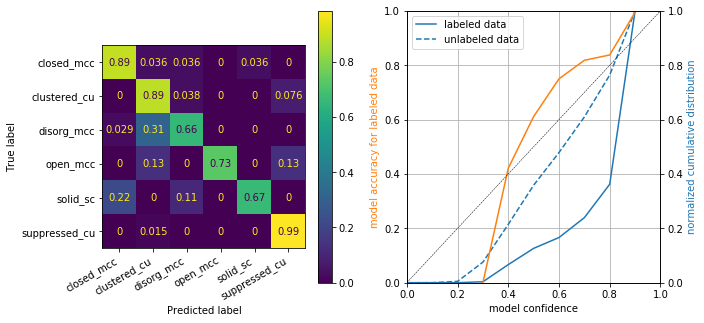

In [139]:
#model calibration
max_probs = np.array(final_certs).squeeze()
true = np.array(final_labels)
preds = np.array(final_preds)
other_max_probs = np.array(other_certs).squeeze()
confs = np.arange(0,1,0.1)
cum_confs = np.zeros_like(confs)
other_cum_confs = np.zeros_like(confs)
mean_scores = np.zeros_like(confs)
gt_scores = np.zeros_like(confs)
conf_dens = np.zeros_like(confs)
other_conf_dens = np.zeros_like(confs)
for i,c in enumerate(confs):
    where_conf = np.logical_and(max_probs>c, max_probs<(c+np.diff(confs)[2]))
    other_where_conf = np.logical_and(other_max_probs>c, other_max_probs<(c+np.diff(confs)[2]))
    where_gt_conf = max_probs>c
    mean_scores[i] =np.sum(preds[where_conf]==true[where_conf])/np.sum(where_conf)
    gt_scores[i] = np.sum(preds[where_gt_conf]==true[where_gt_conf])/np.sum(where_gt_conf)
    cum_confs[i] = np.sum(max_probs<c+np.diff(confs)[2])/len(max_probs)
    other_cum_confs[i] = np.sum(other_max_probs<c+np.diff(confs)[2])/len(other_max_probs)
    
    conf_dens[i] = np.sum(where_conf)/len(where_conf)
    other_conf_dens[i] = np.sum(other_where_conf)/len(other_where_conf)


fig, [ax1, ax2] = plt.subplots(figsize=(10, 5), ncols=2)
conf_matrix = confusion_matrix(y_true=true, y_pred=preds, normalize='true')
cm_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
cm_disp.plot(ax=ax1, xticks_rotation=30)
ax1.set_xticklabels([i.get_text() for i in ax1.get_xticklabels()], ha='right')

# plot_confusion_matrix(model, rot_norm_pcs_test, y_true=test_cats, display_labels=[labels[i] for i in rf.classes_],
#                      normalize='pred', xticks_rotation=30, ax=ax1)
# ax1.set_xticklabels([i.get_text() for i in ax1.get_xticklabels()], ha='right')
p = ax2.plot(confs, cum_confs, label='labeled data')
ax2r = ax2.twinx()

ax2.plot(confs, other_cum_confs, c=p[0].get_color(), ls='--', label='unlabeled data')
acc = ax2.plot(confs, mean_scores)#, label='model accuracy')
ax2r.set_ylabel('normalized cumulative distribution', c=p[0].get_color())
# ax2.plot(confs, gt_scores, label='cum. accuracy above threshold')
ax2.plot((0,1),(0,1),'--k', lw=0.5)
ax2.set_xlabel('model confidence')
ax2.set_ylabel('model accuracy for labeled data', c=acc[0].get_color())
ax2.set_xlim((0,1))
ax2.set_ylim((0,1))
ax2.grid(True)
ax2.legend()
fig.savefig('/home/disk/p/jkcm/plots/dissertation/CNN_model_performance.png', bbox_inches='tight')

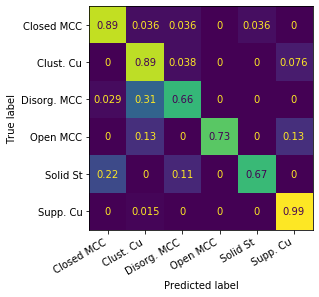

In [158]:
fig, ax1 = plt.subplots(figsize=(5, 5), ncols=1)
conf_matrix = confusion_matrix(y_true=true, y_pred=preds, normalize='true')
short_labels = ['Closed MCC', 'Clust. Cu', 'Disorg. MCC', 'Open MCC', 'Solid St', 'Supp. Cu']
cm_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=short_labels)
cm_disp.plot(ax=ax1, xticks_rotation=30)
ax1.set_xticklabels([i.get_text() for i in ax1.get_xticklabels()], ha='right')

im = ax1.images        
cb = im[-1].colorbar   
cb.remove()

# # plot_confusion_matrix(model, rot_norm_pcs_test, y_true=test_cats, display_labels=[labels[i] for i in rf.classes_],
# #                      normalize='pred', xticks_rotation=30, ax=ax1)
# # ax1.set_xticklabels([i.get_text() for i in ax1.get_xticklabels()], ha='right')
# p = ax2.plot(confs, cum_confs, label='labeled data')
# ax2r = ax2.twinx()

# ax2.plot(confs, other_cum_confs, c=p[0].get_color(), ls='--', label='unlabeled data')
# acc = ax2.plot(confs, mean_scores)#, label='model accuracy')
# ax2r.set_ylabel('normalized cumulative distribution', c=p[0].get_color())
# # ax2.plot(confs, gt_scores, label='cum. accuracy above threshold')
# ax2.plot((0,1),(0,1),'--k', lw=0.5)
# ax2.set_xlabel('model confidence')
# ax2.set_ylabel('model accuracy for labeled data', c=acc[0].get_color())
# ax2.set_xlim((0,1))
# ax2.set_ylim((0,1))
# ax2.grid(True)
# ax2.legend()
fig.savefig('/home/disk/p/jkcm/plots/defense/CNN_model_confusion.png', bbox_inches='tight')

In [157]:
class_names

# short_labels = {0: 'Closed MCC ', 1: 'Clust. Cu', 2: 'Disorg. MCC',
#         3: 'Open MCC', 4: 'Solid St', 5: 'Supp. Cu'}

['closed_mcc',
 'clustered_cu',
 'disorg_mcc',
 'open_mcc',
 'solid_sc',
 'suppressed_cu']

In [144]:
precision, recall, fscore, support = precision_recall_fscore_support(true, preds)

In [147]:
precision, recall, fscore, support/sum(support)

(array([0.89285714, 0.81395349, 0.82142857, 1.        , 0.85714286,
        0.94326241]),
 array([0.89285714, 0.88607595, 0.65714286, 0.73333333, 0.66666667,
        0.98518519]),
 array([0.89285714, 0.84848485, 0.73015873, 0.84615385, 0.75      ,
        0.96376812]),
 array([0.09302326, 0.26245847, 0.11627907, 0.04983389, 0.02990033,
        0.44850498]))

In [148]:
np.sum(fscore*support/sum(support))

0.8874978801672432

In [114]:
np.sum(other_conf_dens[-2:])

0.3903301886792453

In [115]:
np.sum(conf_dens[-2:])

0.760797342192691

In [87]:
###### classes = np.array(['closed MCC', 'clustered', 'disorg', 'open', 'solid', 'suppressed'])
ax = plot_confusion_matrix(final_labels, final_preds, classes)
per_cat_skill(final_labels, final_preds, classes)

TypeError: only integer scalar arrays can be converted to a scalar index

In [14]:
###### def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [140]:
###### inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

print(out.shape)
imshow(out, title=[class_names[x] for x in classes])

torch.Size([3, 228, 1132])


NameError: name 'imshow' is not defined

In [167]:
###### f = r"/home/disk/eos4/jkcm/Data/MEASURES/classified_data/120data/npz/train/cat1/IMG_MYD02HKM.A2012012.2240.061_index_1792_index_1536_Block128x128.npz"

In [ ]:
###### 

In [ ]:
###### 

In [23]:
###### from PIL import Image
path = f
l = np.load(path)
r = l['Ref_Band2']*256
g = l['Ref_Band4']*256
b = l['Ref_Band7']*256
arr = np.stack([r,g,b], axis=2).astype('uint8')
im = Image.fromarray(arr)
im.show()

NameError: name 'f' is not defined

In [183]:
path

NameError: name 'path' is not defined

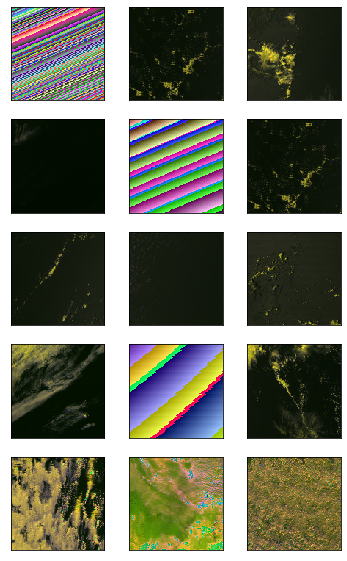

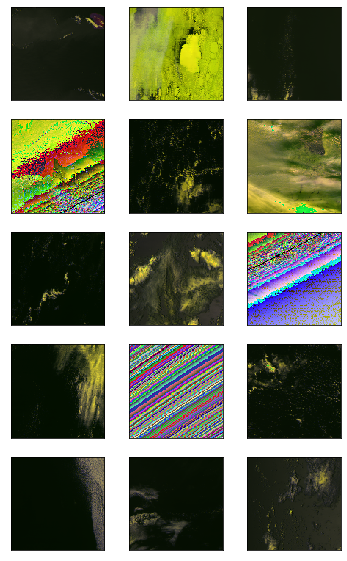

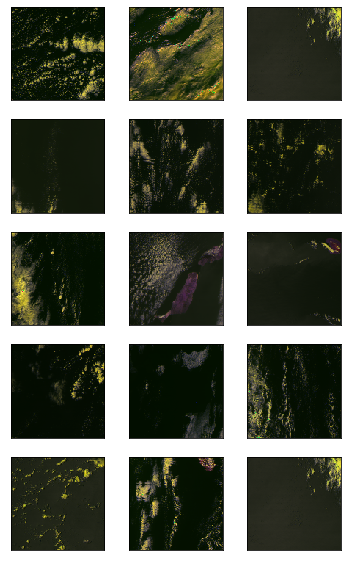

In [189]:
from random import choice

def show_img(path, ax=None):
    l = np.load(path)
    r = l['Ref_Band2']*256
    g = l['Ref_Band4']*256
    b = l['Ref_Band7']*256
    arr = np.stack([r,g,b], axis=2).astype('uint8')
    im = Image.fromarray(arr)
#     im.show()
    if ax:
        ax.imshow(np.asarray(im))
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    else:
        plt.imshow(np.asarray(im))
    
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)
    
basedir = os.path.join(base_dir, "train", "cat5")
list_of_cat3s = [os.path.join(basedir, i) for i in os.listdir(basedir) if valid_file(i)]

def show_randn(imlist, n=1, m=1):
    fig, ax = plt.subplots(ncols=n, nrows=m, figsize=(2*n,2*m))
    for axi in ax.flatten():
        f = choice(imlist)
        show_img(f,axi)
        
show_randn(list_of_cat3s, 3,5)
show_randn(list_of_cat3s, 3, 5)
show_randn(list_of_cat3s, 3,5)

In [159]:
show_randn(list_of_cat3s, 10)


NameError: name 'show_randn' is not defined

In [ ]:
###### 